In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats 
from scipy.ndimage import gaussian_filter1d
import glob
import sys
sys.path.append('./helpers')
import loadmat as lm
import helpers as helpers
import pandas as pd
from sklearn import linear_model
%matplotlib inline

In [3]:
def _fast_occ(occupancy,trials,bins):
    """ calculate occupancy for each position bin returns occupancy bins x trials"""
    
    for i,j in zip(trials,bins):
        if (j<0) or j>=occupancy.shape[0] or i>=occupancy.shape[1]:
            pass
        else:
            occupancy[j,i]+=1

def _fast_bin(counts, trials, bins, neurons):
    """
    Given coordinates of spikes, compile binned spike counts. Throw away
    spikes that are outside of tmin and tmax.
    Turns into a matrix neurons x bins x trials
    """
    for i, j, k in zip(trials, bins, neurons):
        if (j < 0) or (int(j) >= counts.shape[1]) or i>=counts.shape[2]:
            pass
        else:
            counts[k, int(j), i] += 1

In [144]:
class options:
    
    def __init__(self):
        self.speed_t=0.05;
        self.extract_win = [-2,3];
        self.aux_win = [-50,50];
        self.TimeBin = 0.02;
        self.time_bins =np.arange(-2,3,0.02);
        self.extract_win = [-2,3]
        self.speedSigma = 10;
        self.smoothSigma_time = 0.2; # in sec; for smoothing fr vs time
        self.smoothSigma_dist = 2; # in cm; for smoothing fr vs distance
        self.SpatialBin = 2;
        self.TrackStart = 0
        self.TrackEnd = 400
        self.SpeedCutof = 2
        self.stab_thresh = 0.5
        self.max_lag = 30
                
    @property            
    def time_vecs(self):
        return self.time_bins[0:-1]*0.5 + self.time_bins[1:]*0.5
    @property
    def xbinedges(self):
        return np.arange(self.TrackStart,self.TrackEnd+self.SpatialBin,self.SpatialBin)
    @property
    def xbincent(self):
        return self.xbinedges[0:-1]+self.SpatialBin/2




In [193]:
def calculateFiringRateMap(data,trials2extract=None,good_cells = None,ops=None):
    posx=np.mod(data['posx'],ops.TrackEnd)
    post=data['post']
    trial = data['trial'] 
    sp = data['sp']
    if good_cells is None:
        good_cells = sp['cids'][sp['cgs']==2]
    if trials2extract is None:
        trials2extract = np.arange(trial.min(),trial.max()+1)
    
    
    posx_bin = np.digitize(posx,ops.xbinedges)
    validSpikes = np.in1d(data['sp']['clu'],good_cells)
    spike_clu = data['sp']['clu'][validSpikes]
    (bla,spike_idx) = np.unique(spike_clu,return_inverse=True)
    spiketimes = np.digitize(data['sp']['st'][validSpikes],data['post'])
    spikelocations = posx_bin[spiketimes]-1 # to start at 0
    spiketrials = data['trial'][spiketimes] # to start at 0
    
    valid_trialsSpike = np.in1d(spiketrials,trials2extract)
    spiketimes = spiketimes[valid_trialsSpike]
    spikelocations = spikelocations[valid_trialsSpike]
    spiketrials = spiketrials[valid_trialsSpike]
    spike_idx=spike_idx[valid_trialsSpike] 
    
    valid_trials = np.in1d(trial,trials2extract)
    occupancy = np.zeros((len(ops.xbinedges)-1,len(trials2extract)),dtype = float)
    
    _fast_occ(occupancy,trial[valid_trials]-trials2extract[0],posx_bin[valid_trials]-1)
    occupancy *=opt.TimeBin
    
    n_cells = len(good_cells)
    shape = (n_cells, len(opt.xbinedges)-1, len(trials2extract))
    counts = np.zeros(shape, dtype=float)
    _fast_bin(counts,spiketrials-spiketrials.min(),spikelocations,spike_idx)
    spMapN = np.zeros(counts.shape)
    stab =np.zeros(n_cells)
    for iC in range(n_cells):
        tmp = np.divide(counts[iC,:,:],occupancy)
        df = pd.DataFrame(tmp)
        df.interpolate(method='pchip', axis=0, limit=None, inplace=True)
        tmp = df.values
        #print((np.isnan(tmp).sum()))
        tmp_f = gaussian_filter1d(tmp,opt.smoothSigma_dist, axis=0,mode='wrap')
        spMapN[iC]=tmp_f
        cc=np.corrcoef(np.transpose(tmp_f))
        

        stab[iC]=np.nanmean(cc[np.triu(np.full(cc.shape,True),1)])
    
    return counts,spMapN,stab
    
    

In [198]:
data = lm.loadmat(r"F:\attialex\NP_DATA_corrected\npI3_0424_baseline_1.mat")

In [219]:
opt = options()
good_cells = data['sp']['cids'][data['sp']['cgs']==2]
counts,spMapN,stab=calculateFiringRateMap(data,good_cells=good_cells,trials2extract = np.arange(3,21),ops=opt)

C:\Users\attialex\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\attialex\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


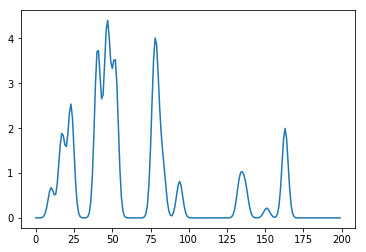

In [154]:
plt.plot(spMapN[0,:,1])

In [226]:
stableMaps = spMapN[stab>0.5]
stableMaps = stableMaps.mean(axis=2)
stableMaps = scipy.stats.zscore(stableMaps,axis=1)
stableMaps.shape



(21, 200)

In [227]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [229]:
X_new=pca.fit_transform(stableMaps.T)

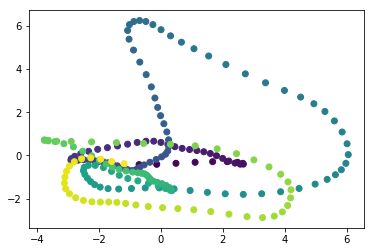

In [232]:
plt.scatter(X_new[:,0],X_new[:,1],c=np.arange(200))